# Problem Formulation

>**The problem:** 

This is a bioassay task for anticancer activity prediction, where we need to know if  the chemical compound is positive against non-small cell lung cancer, or negative otherwise.

>**input:**

A dataset where each chemical compound is represented as a graph, with atoms representing nodes and bonds as edges.The input file is structure data file (SDF).

>**output:**

Predictions of anticancer activity prediction task (labels) where:
* 1 means possitive
* 0 means negative


>**Data Minning Function**

This is a classification & prediction task.


>**The challanges could be**

dealing with SDF format, dealing with graphs, feature selection, feature engineering, not enough training data, data imbalance, overfitting or underfitting.


> **The impact:**

This can be very useful application of finding the best treatment for lung cancer patients, and in general this could save e lot of effort and time for patients with cancer instead of trying many treatment protocols on them which is very exhausting process.



> **The ideal solution**

is to select and design a machine learning model that predict the best chemical compund that is most effective in lung cancer treatment.

# Questions ❓

> 🌈 Based on the provided template, describe the format of the input file (sdf file).

* It's a chemical-data file formats that contains multiple records delimited by lines consisting of four dollar signs `$$$$`. It stores multiple molecules in a single file .It also store information about position of chemical compound atoms and the connections betwwen them.

* Each molecule starts with the name of the compound. Other sections includes information about Atom count, version number, edge connections.
- 1st block is atom block contains elements of the compound (nodes).
- 2nd block is bond block contains the bonds between atoms of the compound (edges). 

> 🌈 What are the input tensors to the neural network model (their meaning, not just symbol)? What is each of their dims and their meaning (e.g. batch_size)?

The input tensors in this network are:

* data: It contains the tokenized chemical compound atoms(nodes). Each compound's nodes are retrieved, tokenized with the help of a tokenizer, and then padded using the pad_sequence technique. Each batch has the shape [batch_size*max_len_nodes], where `batch_size` denotes the number of samples in the batch and `max_len_nodes` denotes the length of tokenized nodes following padding.

* edge: It's the input tensor that contains information on atom connections. Edges have the shape [sum_of_all_edges,2]. The number of edges in each sample is represented by the total of all edges, or batch size.

* node2graph: This input tensor, which provides details about segmented ids, is used for segmented mean. Each batch has the shape [batch_size*max_len_nodes], where `batch_size` denotes the number of samples in the batch and `max_len_nodes` denotes the length of tokenized nodes following padding.

> 🌈 For each dim of gnn_out, what does it symbolize? For each dim of avg, what does it symbolize?

* gnn_out: The shape of the `gnn_out` is [batch_size_node_dimension,hidden layers], where `batch_size_node_dimension` is the dimension of the input data (node) vector (dimension of tokenized vector for the entire batch). It represents the model's aggregation output for each hidden layer.

*  avg: Average computes the segmented mean of the `gnn_out` based on the segmented ids. The output of `gnn_out` for each sample in the `batch_size` is [tokenized_vector_dimension, hidden_layers]. Each sample has a unique segment id. Thus, `segment_mean` takes the mean of all the output data in the `gnn_out` output and represents one sample with one number for each hidden layer. The average tensor's final output is of the form [batch_size, hidden_layer]. It is a method of collecting information for each sample and presenting it as mean data.


> 🌈 What is the difference between segment_mean and tf.reduce_mean? For each dim of pred, what does it symbolize?

* segment_mean computes the mean of data with the same segmented ids.

* reduce_mean: computes the mean of a tensor's elements across dimensions given the parameters.
  - To calculate the mean of tensor elements along various dimensions of the tensor, we used the TensorFlow reduce_mean method.

* pred: The final output (pred) indicates whether a chemical substance is active for cancer cells or not. Pred has the shape [batch_size,1]. Thus, the final output for each sample is a number that represents the probability of each chemical compound's activity.

> 🌈 What is the motivation/theory/idea to use multiple gcn layers comparing to just one? How many layers were used in the template?

* As Graph Convolutional Networks (GCNs) are a type of neural network that can operate on graph-structured data such as social networks or citation networks. By stacking multiple GCN layers, the information can be propagated across far reaches of a graph, which makes GCNs capable of learning from both content information as well as graph structure. In particular, GCN has a powerful ability to model higher-order neighborhood interactions by stacking multiple layers. Therefore, using multiple GCN layers can help capture more complex patterns in the data and improve the performance of the model.

* 4 layers were used in thr=e template  


# Implementation ⏭

## Important libraries

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!pip install --quiet tf2_gnn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.9/54.9 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.3/73.3 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.0/388.0 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 41.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.5/135.5 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.0/90.0 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.9/173.9 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 2.6 MB/s eta 0:00:00


In [20]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 
%matplotlib inline
import sklearn
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, precision_score, recall_score, f1_score, precision_recall_curve
from tqdm.notebook import tqdm
import os
import math
sns.set()

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from time import time
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.utils import resample 
import tensorflow as tf
from tensorflow.math import segment_mean
from tensorflow import keras
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Embedding, Dense
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.layers import Conv2D, MaxPool2D
from tensorflow.keras.layers import Flatten, Dropout
from tensorflow.keras.layers import GRU, LSTM, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tf2_gnn.layers.gnn import GNN, GNNInput
from tf2_gnn.layers.message_passing import GNN_Edge_MLP, GNN_FiLM

import warnings
warnings.filterwarnings('ignore')

pd.options.display.max_columns = 100
pd.options.display.max_rows = 300
pd.options.display.max_colwidth = 100
np.set_printoptions(threshold=2000)

from tensorflow.keras.preprocessing.sequence import pad_sequences
import random
random.seed(10)

!pip install --quiet tf2_gnn
from tf2_gnn.layers.gnn import GNN, GNNInput

## Loading data

In [4]:
# A function to read sdf files

def read_sdf(file):
    with open(file, 'r') as rf:
        content = rf.read()
    samples = content.split('$$$$') ## split values by '$$$$' and put them in a list


## A function to analyze the file content (samples)
    def parse_sample(s):
        lines = s.splitlines() ## divide it to lines
        links = []            ## a list to contain edges
        nodes = []
        label = 0
        for l in lines:
          # label conversion
            if l.strip() == '1.0':
                label = 1
            if l.strip() == '-1.0':
                label = 0
              # lines of nodes starts with 4 spaces
            if l.startswith('    '):
                feature = l.split()
                node = feature[3]  # the symbols of chemical elements
                nodes.append(node)
              # lines of edges starts with 2 spaces
            elif l.startswith(' '):
                lnk = l.split()
                # edge: (from, to,) (1-based index)
                if int(lnk[0]) - 1 < len(nodes):
                    links.append((
                        int(lnk[0])-1, 
                        int(lnk[1])-1, # zero-based index
                        # int(lnk[2]) ignore edge weight
                    ))
        return nodes, np.array(links), label
    
    return [parse_sample(s) for s in tqdm(samples) if len(s[0]) > 0]
                

In [5]:
train = read_sdf('/content/gdrive/MyDrive/competition 5/train.sdf')
test = read_sdf('/content/gdrive/MyDrive/competition 5/test_x.sdf')

  0%|          | 0/25024 [00:00<?, ?it/s]

  0%|          | 0/12326 [00:00<?, ?it/s]

In [6]:
# check data 
print(train[0:7])

[(['S', 'O', 'O', 'O', 'O', 'N', 'N', 'N', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C'], array([[ 0,  8],
       [ 0, 14],
       [ 1, 10],
       [ 2, 11],
       [ 3,  7],
       [ 4,  7],
       [ 5,  9],
       [ 5, 14],
       [ 6, 14],
       [ 6, 17],
       [ 7, 22],
       [ 8,  9],
       [ 8, 10],
       [ 9, 11],
       [10, 12],
       [11, 13],
       [12, 13],
       [12, 15],
       [13, 16],
       [15, 18],
       [16, 19],
       [17, 20],
       [17, 21],
       [18, 19],
       [20, 23],
       [21, 24],
       [22, 23],
       [22, 24]]), 0), (['O', 'O', 'O', 'O', 'O', 'O', 'N', 'N', 'N', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C'], array([[ 0,  6],
       [ 0, 15],
       [ 1, 15],
       [ 2,  7],
       [ 3,  8],
       [ 4,  7],
       [ 5,  8],
       [ 6,  9],
       [ 7, 16],
       [ 8, 17],
       [ 9, 10],
       [ 9, 11],
       [10, 12],
       [10

## Data Visualization

In [7]:
!pip install --quiet networkx

In [8]:
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import cm
colors = cm.Spectral(np.linspace(0, 1, 70))

In [9]:
# A function to visualize samples
def visualize(sample):
  # Graph instance
    graph=nx.Graph()
    nodes = sample[0]  # fisrt feature is nodes
    edges = sample[1]  # second feature is edges

    # A dictionary to represent node symbols with numbers 
    labeldict={}
    node_color=[]
    for i,n in enumerate(nodes):
        graph.add_node(i)
        labeldict[i]=n
        # color coding for each node
        node_color.append(colors[hash(n)%len(colors)])

    # a list of nodes:
    for e in edges:
        graph.add_edge(e[0], e[1])
        
    nx.draw_networkx(graph, labels=labeldict, with_labels = True, node_color = node_color)
    plt.show()
    
    return graph

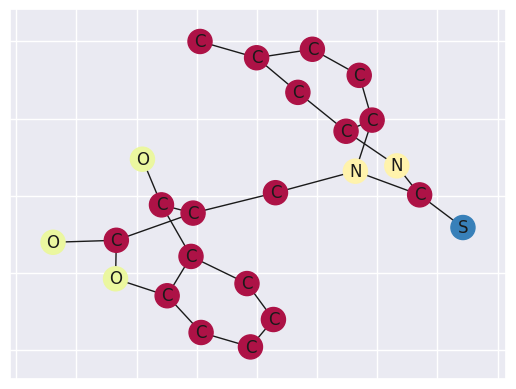

In [10]:
plt.clf()
visualize(train[7])

In [11]:
# convert train into DataFrame
train_df = pd.DataFrame(train, columns=['node','edge','label']) 

In [12]:
train_df

,node,edge,label
0,"[S, O, O, O, O, N, N, N, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C]","[[0, 8], [0, 14], [1, 10], [2, 11], [3, 7], [4, 7], [5, 9], [5, 14], [6, 14], [6, 17], [7, 22], ...",0
1,"[O, O, O, O, O, O, N, N, N, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C]","[[0, 6], [0, 15], [1, 15], [2, 7], [3, 8], [4, 7], [5, 8], [6, 9], [7, 16], [8, 17], [9, 10], [9...",0
2,"[F, F, F, O, O, O, O, O, N, N, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C,...","[[0, 19], [1, 19], [2, 19], [3, 16], [4, 28], [4, 32], [5, 28], [6, 29], [6, 33], [7, 29], [8, 1...",0
3,"[Cl, S, S, O, O, O, O, N, N, N, N, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C]","[[0, 12], [1, 15], [1, 18], [2, 4], [2, 5], [2, 6], [2, 23], [3, 13], [7, 11], [7, 13], [7, 15],...",0
4,"[S, O, O, N, N, N, N, N, N, C, C, C, C, C, C, C, C, C, C, C]","[[0, 1], [0, 2], [0, 5], [0, 9], [3, 4], [3, 10], [4, 16], [6, 13], [6, 18], [7, 17], [7, 19], [...",0
...,...,...,...
25019,"[O, O, O, O, O, O, N, N, C, C, C, C, C, C, C, C, C, C, C, C, C, C]","[[0, 8], [0, 14], [1, 10], [2, 12], [3, 13], [4, 7], [5, 7], [6, 8], [6, 9], [6, 15], [7, 18], [...",0
25020,"[O, O, O, O, O, N, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C]","[[0, 9], [1, 11], [2, 16], [2, 19], [3, 16], [4, 15], [5, 18], [6, 7], [6, 8], [6, 13], [7, 10],...",0
25021,"[O, O, O, O, O, O, O, O, O, N, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C,...","[[0, 12], [0, 16], [1, 10], [2, 11], [3, 15], [4, 16], [5, 17], [6, 18], [6, 27], [7, 20], [8, 2...",0
25022,"[S, O, O, O, O, N, N, N, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C]","[[0, 11], [0, 12], [1, 21], [1, 27], [2, 22], [2, 28], [3, 21], [4, 22], [5, 8], [5, 12], [6, 13...",0


In [13]:
train_df.label.value_counts()
# data is imbalanced I will handle it by class weights

0    23806
1     1218
Name: label, dtype: int64

## Data splitting

In [14]:
# split data into train & validation by 85 to 15 
training_set, validation_set = train_test_split(train, test_size=0.15)

## Data preprocessing

In [15]:
all_nodes = [s[0] for s in training_set]
# get max length of nodes
longest = 0
for value in all_nodes:
    longest = max(longest, len(value))                                                                                                                                                                                                                             

In [16]:
max_vocab = 700
max_len = longest  # max number of nodes in a molecules
# build vocabulary from training set
tokenizer = Tokenizer(num_words=max_vocab)
tokenizer.fit_on_texts(all_nodes)

In [17]:
# A function to prepare single batch
def prepare_single_batch(samples): # samples parameter = a list of samples (molecules)
 # extract nodes symbols from each sample 
    sample_nodes = [s[0] for s in samples]  
# tokenize nodes                   
    sample_nodes = tokenizer.texts_to_sequences(sample_nodes)   
# pad_sequences for post padding the nodes
    sample_nodes = pad_sequences(sample_nodes, padding='post')  
# max length of nodes 
    max_nodes_len = np.shape(sample_nodes)[1]                   
#  edges
    edges = [s[1]+i*max_nodes_len for i,s in enumerate(samples)] 
    edges = [e for e in edges if len(e) > 0]
# segmented_ids array
    node_to_graph = [[i]*max_nodes_len for i in range(len(samples))]  
    all_nodes = np.reshape(sample_nodes, -1)  
# concatenate the edges as size [total_edges ,2]
    all_edges = np.concatenate(edges)         
# which node belong to which graph
    node_to_graph = np.reshape(node_to_graph, -1)
# returns a dictionary of features(data,edges,node2grah) and label
    return {
        'data': all_nodes,
        'edges': all_edges,
        'node2grah': node_to_graph,
    }, np.array([s[2] for s in samples]) 


# A function to generate batch with given batch_size
def gen_batch(dataset, batch_size=16, repeat=False, shuffle=True):
    while True:  
      # put dataset in a list to shuffle it              
        dataset = list(dataset) 
        if shuffle:             
            random.shuffle(dataset) 
        l = len(dataset)  
        for ndx in range(0, l, batch_size):  
            batch_samples = dataset[ndx:min(ndx + batch_size, l)] 
            yield prepare_single_batch(batch_samples)  
        if not repeat:  
            break


In [22]:
# showing one batch:
for train_batch in gen_batch(training_set, batch_size=4):
    for k,v in train_batch[0].items():
        print(k)
        print(v)
        pass
    print('label', train_batch[1])
    break

data
[2 2 2 2 2 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 2 2 2 3 3 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 5 2 2 3 3 3 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 5 5 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0]
edges
[[ 0  7]
 [ 1 10]
 [ 2 16]
 [ 3  6]
 [ 4  6]
 [ 5 10]
 [ 5 11]
 [ 6 17]
 [ 7  8]
 [ 7  9]
 [ 7 10]
 [ 8 11]
 [ 8 15]
 [ 9 12]
 [ 9 14]
 [11 18]
 [12 13]
 [12 19]
 [13 16]
 [13 21]
 [14 16]
 [15 17]
 [17 20]
 [18 20]
 [19 22]
 [21 23]
 [22 23]
 [26 38]
 [26 44]
 [27 37]
 [28 43]
 [29 33]
 [29 34]
 [30 41]
 [30 43]
 [31 32]
 [31 33]
 [31 36]
 [32 34]
 [32 39]
 [33 35]
 [34 37]
 [35 38]
 [36 40]
 [37 42]
 [38 40]
 [39 41]
 [43 45]
 [52 75]
 [53 62]
 [54 66]
 [55 60]
 [55 61]
 [55 62]
 [56 60]
 [56 65]
 [57 58]
 [57 64]
 [58 72]
 [59 69]
 [60 63]
 [61 65]
 [61 67]
 [62 64]
 [63 66]
 [63 69]
 [64 66]
 [65 68]
 [67 70]
 [68 71]
 [70 71]
 [72 73]
 [72 74]
 [73 76]
 [74 77]
 [75 76]
 [75 77]
 [78 95]
 [79 96]
 [80 81]
 [80 91]
 [81 85]
 [81 86]
 [81 87]
 [82 85]
 [82 88]
 [8

## Trials


In [23]:
# A function to save the submission files
def saveResult(y_pred, fileName):
  submission = pd.DataFrame({'label': y_pred})
  submission.index.name = 'id'
  
  submission.to_csv(fileName)

### Trial 0 

In [24]:
# Model Building 

# Nodes Input layer 
data = keras.Input(batch_shape=(None,))  


# the first dim is different to the previous one. it is the total number of edges in this batch
# Edge Input layer
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
# node2graph Input layer
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)
# Embedding layer 
embeded = Embedding(tokenizer.num_words, 20)(data)

# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1

# GNNInput takes the features of sample ( node, the edge, the created list 'node2graph', and number of graphs (number of samples))
gnn_input = GNNInput(
    node_features = embeded,
    adjacency_lists = (edge,),
    node_to_graph_map = node2graph, 
    num_graphs = num_graph,
)


# hyperparameters of GNN layers
# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py

# defualt hyperparameters
params = GNN.get_default_hyperparameters()
# size of the output of all message passing layers
params["hidden_dim"] = 32
gnn_layer = GNN(params)
gnn_out = gnn_layer(gnn_input)
print('gnn_out', gnn_out)


# Computes the segmented mean based on segment_ids
# https://www.tensorflow.org/api_docs/python/tf/math/segment_mean
avg = segment_mean(
    data = gnn_out,
    segment_ids = node2graph
)
print('mean:', avg)

# output layer
pred = Dense(1, activation='sigmoid')(avg)
print('pred:', pred)


# model building
model = Model(
    inputs = {
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs = pred
)
# summary of the model
model.summary()

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='gnn/StatefulPartitionedCall:0', description="created by layer 'gnn'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='tf.math.segment_mean/SegmentMean:0', description="created by layer 'tf.math.segment_mean'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense/Sigmoid:0', description="created by layer 'dense'")
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None,)]            0           []                      

In [25]:
# Model Compiling 
model.compile( optimizer='adam',
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

In [27]:
# Model Training

batch_size = 16
# math.ceil: to get the nearest integer of batches for training data
num_batchs = math.ceil(len(training_set) / batch_size)
# num of batches for validation data
num_batchs_validation = math.ceil(len(validation_set) / batch_size)
# model training
model.fit(
    gen_batch(training_set, batch_size = batch_size, repeat=True),
    steps_per_epoch = num_batchs,
    epochs=15,
    validation_data = gen_batch(validation_set, batch_size = batch_size, repeat=True),
    validation_steps = num_batchs_validation,
)

Epoch 1/15
1330/1330 [==============================] - 24s 18ms/step - loss: 0.1772 - auc: 0.7033 - val_loss: 0.1947 - val_auc: 0.7418
Epoch 2/15
1330/1330 [==============================] - 27s 20ms/step - loss: 0.1766 - auc: 0.7064 - val_loss: 0.1822 - val_auc: 0.7537
Epoch 3/15
1330/1330 [==============================] - 28s 21ms/step - loss: 0.1761 - auc: 0.7184 - val_loss: 0.2047 - val_auc: 0.7296
Epoch 4/15
1330/1330 [==============================] - 23s 17ms/step - loss: 0.1744 - auc: 0.7263 - val_loss: 0.1769 - val_auc: 0.7324
Epoch 5/15
1330/1330 [==============================] - 25s 19ms/step - loss: 0.1740 - auc: 0.7236 - val_loss: 0.1926 - val_auc: 0.7475
Epoch 6/15
1330/1330 [==============================] - 27s 20ms/step - loss: 0.1736 - auc: 0.7243 - val_loss: 0.1862 - val_auc: 0.7405
Epoch 7/15
1330/1330 [==============================] - 26s 19ms/step - loss: 0.1720 - auc: 0.7429 - val_loss: 0.1781 - val_auc: 0.7476
Epoch 8/15
1330/1330 [==========================

In [28]:
# predictions on test data
y_pred = model.predict(gen_batch(test, batch_size=16, shuffle=False))
y_pred = np.reshape(y_pred, -1)


771/771 [==============================] - 7s 8ms/step


In [29]:
# submission file
saveResult(y_pred, 'trial0.csv')

> Thoughts and observations for trial 0: 

I used **Graph Neural Network** with :

* NO data balance techniques 
* A GNN layer with defualt hyperparameters.
* `hidden_dim` = 32 (size of the output of all message passing layers)
* another GNN layer with the defined hyperparameters and calculated segmented mean based on segment_ids
* model compiling : 
  - BinaryCrossentropy for loss 
  - AUC to measure the model's performance.


In the training:
* batch size = 16 
* epochs = 15 
* validated the model using the `validation_set`

From the result, unbalanced data had a bad effect on the model's accuracy and cause bad performance.

> plan for trial 1: 

apply a data balance technichque (class weighting)

### Trial 1

In [30]:
# Model Training

batch_size = 16
# math.ceil: to get the nearest integer of batches for training data
num_batchs = math.ceil(len(training_set) / batch_size)
# num of batches for validation data
num_batchs_validation = math.ceil(len(validation_set) / batch_size)
# model training
model.fit(
    gen_batch(training_set, batch_size = batch_size, repeat=True),
    steps_per_epoch = num_batchs,
    epochs=15,
    validation_data = gen_batch(validation_set, batch_size = batch_size, repeat=True),
    validation_steps = num_batchs_validation,
    class_weight = {0: 1, 1: 20},
)

Epoch 1/15
1330/1330 [==============================] - 31s 21ms/step - loss: 1.1940 - auc: 0.7141 - val_loss: 0.6457 - val_auc: 0.7334
Epoch 2/15
1330/1330 [==============================] - 23s 18ms/step - loss: 1.1410 - auc: 0.7427 - val_loss: 0.5629 - val_auc: 0.7417
Epoch 3/15
1330/1330 [==============================] - 27s 21ms/step - loss: 1.1250 - auc: 0.7522 - val_loss: 0.5504 - val_auc: 0.7466
Epoch 4/15
1330/1330 [==============================] - 24s 18ms/step - loss: 1.1164 - auc: 0.7581 - val_loss: 0.6274 - val_auc: 0.7514
Epoch 5/15
1330/1330 [==============================] - 31s 23ms/step - loss: 1.1124 - auc: 0.7613 - val_loss: 0.5293 - val_auc: 0.7590
Epoch 6/15
1330/1330 [==============================] - 32s 24ms/step - loss: 1.1031 - auc: 0.7710 - val_loss: 0.6155 - val_auc: 0.7664
Epoch 7/15
1330/1330 [==============================] - 34s 25ms/step - loss: 1.0871 - auc: 0.7761 - val_loss: 0.6255 - val_auc: 0.7618
Epoch 8/15
1330/1330 [==========================

In [31]:
# predictions on test data
y_pred = model.predict(gen_batch(test, batch_size=16, shuffle=False))
y_pred = np.reshape(y_pred, -1)


771/771 [==============================] - 6s 8ms/step


In [32]:
# submission file
saveResult(y_pred, 'trial1.csv')

> Thoughts and observations for trial 1: 
(the same model)
I used **Graph Neural Network** with :

* A GNN layer with defualt hyperparameters.
* `hidden_dim` = 32 (size of the output of all message passing layers)
* another GNN layer with the defined hyperparameters and calculated segmented mean based on segment_ids
* model compiling : 
  - BinaryCrossentropy for loss 
  - AUC to measure the model's performance.


In the training:
* batch size = 16 
* epochs = 15 
* validated the model using the `validation_set`
* added the class weights while training to deal with data imbalance

From the result, after we applied the calss weighting to balance data the performance got better results that the first model.

> plan for trial 2: 

* add the class weight to all the upcoming trial 
* Try to apply one of the GCN aggregation mechanisms by tuning the message_passing mechanisms and configure the message passing style to be GGNN

### Trial 2

In [33]:
# Model Building 

# Nodes Input layer 
data = keras.Input(batch_shape=(None,))  


# the first dim is different to the previous one. it is the total number of edges in this batch
# Edge Input layer
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
# node2graph Input layer
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)
# Embedding layer 
embeded = Embedding(tokenizer.num_words, 20)(data)

# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1

# GNNInput takes the features of sample ( node, the edge, the created list 'node2graph', and number of graphs (number of samples))
gnn_input = GNNInput(
    node_features = embeded,
    adjacency_lists = (edge,),
    node_to_graph_map = node2graph, 
    num_graphs = num_graph,
)


# hyperparameters of GNN layers
# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py

# defualt hyperparameters
params = GNN.get_default_hyperparameters()
# size of the output of all message passing layers
params["hidden_dim"] = 32
# configures the message passing style to be GGNN (Gated Graph Neural Networks)
params['message_calculation_class'] = 'GGNN'

gnn_layer = GNN(params)
gnn_out = gnn_layer(gnn_input)
print('gnn_out', gnn_out)


# Computes the segmented mean based on segment_ids
# https://www.tensorflow.org/api_docs/python/tf/math/segment_mean
avg = segment_mean(
    data = gnn_out,
    segment_ids = node2graph
)
print('mean:', avg)

# output layer
pred = Dense(1, activation='sigmoid')(avg)
print('pred:', pred)


# model building
model = Model(
    inputs = {
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs = pred
)
# summary of the model
model.summary()

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='gnn_1/StatefulPartitionedCall:0', description="created by layer 'gnn_1'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='tf.math.segment_mean_1/SegmentMean:0', description="created by layer 'tf.math.segment_mean_1'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_1/Sigmoid:0', description="created by layer 'dense_1'")
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None,)]            0           []        

In [34]:
# Model Compiling 
model.compile( optimizer='adam',
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

In [36]:
# Model Training

batch_size = 16
# math.ceil: to get the nearest integer of batches for training data
num_batchs = math.ceil(len(training_set) / batch_size)
# num of batches for validation data
num_batchs_validation = math.ceil(len(validation_set) / batch_size)
# model training
model.fit(
    gen_batch(training_set, batch_size = batch_size, repeat=True),
    steps_per_epoch = num_batchs,
    epochs=15,
    validation_data = gen_batch(validation_set, batch_size = batch_size, repeat=True),
    validation_steps = num_batchs_validation,
    class_weight = {0: 1, 1: 20},
)

Epoch 1/15
1330/1330 [==============================] - 43s 32ms/step - loss: 1.0608 - auc: 0.7861 - val_loss: 0.6621 - val_auc: 0.7689
Epoch 2/15
1330/1330 [==============================] - 42s 32ms/step - loss: 1.0561 - auc: 0.7879 - val_loss: 0.5049 - val_auc: 0.7885
Epoch 3/15
1330/1330 [==============================] - 40s 30ms/step - loss: 1.0405 - auc: 0.7976 - val_loss: 0.6012 - val_auc: 0.7963
Epoch 4/15
1330/1330 [==============================] - 40s 30ms/step - loss: 1.0391 - auc: 0.7983 - val_loss: 0.5965 - val_auc: 0.7573
Epoch 5/15
1330/1330 [==============================] - 47s 35ms/step - loss: 1.0610 - auc: 0.7859 - val_loss: 0.5175 - val_auc: 0.7948
Epoch 6/15
1330/1330 [==============================] - 47s 35ms/step - loss: 1.0406 - auc: 0.7973 - val_loss: 0.5993 - val_auc: 0.7709
Epoch 7/15
1330/1330 [==============================] - 47s 35ms/step - loss: 1.0289 - auc: 0.8003 - val_loss: 0.4822 - val_auc: 0.7936
Epoch 8/15
1330/1330 [==========================

In [37]:
# predictions on test data
y_pred = model.predict(gen_batch(test, batch_size=16, shuffle=False))
y_pred = np.reshape(y_pred, -1)


771/771 [==============================] - 7s 9ms/step


In [38]:
# submission file
saveResult(y_pred, 'trial2.csv')

> Thoughts and observations for trial 2: 

I used **Graph Neural Network** with :

* A GNN layer with defualt hyperparameters.
* `hidden_dim` = 32 (size of the output of all message passing layers)
* another GNN layer with the defined hyperparameters and calculated segmented mean based on segment_ids
* GCN aggregation mechanisms by tuning the message_passing mechanisms and set `message_calculation_class` parameter  = `GGNN`


* model compiling : 
  - BinaryCrossentropy for loss 
  - AUC to measure the model's performance.


In the training:
* batch size = 16 
* epochs = 15 
* validated the model using the `validation_set`
* added the class weights while training to deal with data imbalance

From the result, findings are far superior to utilizing the model without GCN aggregation methods.

> plan for trial 3: 

* Try to apply another one of the GCN aggregation mechanisms by tuning the message_passing mechanisms and configure the message passing style to be RGCN.

### Trial 3


In [53]:
# Model Building 

# Nodes Input layer 
data = keras.Input(batch_shape=(None,))  


# the first dim is different to the previous one. it is the total number of edges in this batch
# Edge Input layer
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
# node2graph Input layer
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)
# Embedding layer 
embeded = Embedding(tokenizer.num_words, 20)(data)

# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1

# GNNInput takes the features of sample ( node, the edge, the created list 'node2graph', and number of graphs (number of samples))
gnn_input = GNNInput(
    node_features = embeded,
    adjacency_lists = (edge,),
    node_to_graph_map = node2graph, 
    num_graphs = num_graph,
)


# hyperparameters of GNN layers
# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py

# defualt hyperparameters
params = GNN.get_default_hyperparameters()
# size of the output of all message passing layers
params["hidden_dim"] = 32
# configures the message passing style to be RGCN (Relational Graph Convolutional Networks)
params['message_calculation_class'] = 'RGCN'

gnn_layer = GNN(params)
gnn_out = gnn_layer(gnn_input)
print('gnn_out', gnn_out)


# Computes the segmented mean based on segment_ids
# https://www.tensorflow.org/api_docs/python/tf/math/segment_mean
avg = segment_mean(
    data = gnn_out,
    segment_ids = node2graph
)
print('mean:', avg)

# output layer
pred = Dense(1, activation='sigmoid')(avg)
print('pred:', pred)


# model building
model = Model(
    inputs = {
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs = pred
)
# summary of the model
model.summary()

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='gnn_6/StatefulPartitionedCall:0', description="created by layer 'gnn_6'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='tf.math.segment_mean_6/SegmentMean:0', description="created by layer 'tf.math.segment_mean_6'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_6/Sigmoid:0', description="created by layer 'dense_6'")
Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_21 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_19 (InputLayer)          [(None,)]            0           []        

In [54]:
# Model Compiling 
model.compile( optimizer='adam',
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

In [55]:
# Model Training

batch_size = 16
# math.ceil: to get the nearest integer of batches for training data
num_batchs = math.ceil(len(training_set) / batch_size)
# num of batches for validation data
num_batchs_validation = math.ceil(len(validation_set) / batch_size)
# model training
model.fit(
    gen_batch(training_set, batch_size = batch_size, repeat=True),
    steps_per_epoch = num_batchs,
    epochs=15,
    validation_data = gen_batch(validation_set, batch_size = batch_size, repeat=True),
    validation_steps = num_batchs_validation,
    class_weight = {0: 1, 1: 20},
)

Epoch 1/15
1330/1330 [==============================] - 31s 20ms/step - loss: 1.2774 - auc: 0.6201 - val_loss: 0.6746 - val_auc: 0.7054
Epoch 2/15
1330/1330 [==============================] - 25s 19ms/step - loss: 1.2144 - auc: 0.6875 - val_loss: 0.6444 - val_auc: 0.7406
Epoch 3/15
1330/1330 [==============================] - 25s 19ms/step - loss: 1.1868 - auc: 0.7099 - val_loss: 0.7274 - val_auc: 0.7320
Epoch 4/15
1330/1330 [==============================] - 28s 21ms/step - loss: 1.1769 - auc: 0.7122 - val_loss: 0.6005 - val_auc: 0.7450
Epoch 5/15
1330/1330 [==============================] - 23s 18ms/step - loss: 1.1690 - auc: 0.7189 - val_loss: 0.6411 - val_auc: 0.7574
Epoch 6/15
1330/1330 [==============================] - 28s 21ms/step - loss: 1.1507 - auc: 0.7326 - val_loss: 0.5606 - val_auc: 0.7491
Epoch 7/15
1330/1330 [==============================] - 27s 20ms/step - loss: 1.1363 - auc: 0.7421 - val_loss: 0.5302 - val_auc: 0.7524
Epoch 8/15
1330/1330 [==========================

In [56]:
# predictions on test data
y_pred = model.predict(gen_batch(test, batch_size=16, shuffle=False))
y_pred = np.reshape(y_pred, -1)


771/771 [==============================] - 6s 7ms/step


In [57]:
# submission file
saveResult(y_pred, 'trial3.csv')

> Thoughts and observations for trial 3: 

I used **Graph Neural Network** with :

* A GNN layer with defualt hyperparameters.
* `hidden_dim` = 32 (size of the output of all message passing layers)
* another GNN layer with the defined hyperparameters and calculated segmented mean based on segment_ids
* GCN aggregation mechanisms by tuning the message_passing mechanisms and set `message_calculation_class` parameter  = `RGAT`



* model compiling : 
  - BinaryCrossentropy for loss 
  - AUC to measure the model's performance.


In the training:
* batch size = 16 
* epochs = 15 
* validated the model using the `validation_set`
* added the class weights while training to deal with data imbalance

> According to the results, the model performs significantly better than when no GCN aggregation techniques are used, but the trail result is lower than when the message_calculation_class option is set to GGNN.

> plan for trial 4: 

* use the same model and set the number of parallel (independent) weighted sums that are computed `num_heads` = 4.

### Trail 4

In [48]:
# Model Building 

# Nodes Input layer 
data = keras.Input(batch_shape=(None,))  


# the first dim is different to the previous one. it is the total number of edges in this batch
# Edge Input layer
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
# node2graph Input layer
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)
# Embedding layer 
embeded = Embedding(tokenizer.num_words, 20)(data)

# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1

# GNNInput takes the features of sample ( node, the edge, the created list 'node2graph', and number of graphs (number of samples))
gnn_input = GNNInput(
    node_features = embeded,
    adjacency_lists = (edge,),
    node_to_graph_map = node2graph, 
    num_graphs = num_graph,
)


# hyperparameters of GNN layers
# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py

# defualt hyperparameters
params = GNN.get_default_hyperparameters()
# size of the output of all message passing layers
params["hidden_dim"] = 32
# configures the message passing style to be RGCN (Relational Graph Convolutional Networks)
params['message_calculation_class'] = 'RGCN'
# configures the number of parallel (independent) weighted sums that are computed, whose results are concatenated to obtain the final result.
params["num_heads"] = 4

gnn_layer = GNN(params)
gnn_out = gnn_layer(gnn_input)
print('gnn_out', gnn_out)


# Computes the segmented mean based on segment_ids
# https://www.tensorflow.org/api_docs/python/tf/math/segment_mean
avg = segment_mean(
    data = gnn_out,
    segment_ids = node2graph
)
print('mean:', avg)

# output layer
pred = Dense(1, activation='sigmoid')(avg)
print('pred:', pred)


# model building
model = Model(
    inputs = {
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs = pred
)
# summary of the model
model.summary()

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='gnn_5/StatefulPartitionedCall:0', description="created by layer 'gnn_5'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='tf.math.segment_mean_5/SegmentMean:0', description="created by layer 'tf.math.segment_mean_5'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_5/Sigmoid:0', description="created by layer 'dense_5'")
Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_18 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_16 (InputLayer)          [(None,)]            0           []        

In [49]:
# Model Compiling 
model.compile( optimizer='adam',
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

In [50]:
# Model Training

batch_size = 16
# math.ceil: to get the nearest integer of batches for training data
num_batchs = math.ceil(len(training_set) / batch_size)
# num of batches for validation data
num_batchs_validation = math.ceil(len(validation_set) / batch_size)
# model training
model.fit(
    gen_batch(training_set, batch_size = batch_size, repeat=True),
    steps_per_epoch = num_batchs,
    epochs=15,
    validation_data = gen_batch(validation_set, batch_size = batch_size, repeat=True),
    validation_steps = num_batchs_validation,
    class_weight = {0: 1, 1: 20},
)

Epoch 1/15
1330/1330 [==============================] - 32s 21ms/step - loss: 1.2763 - auc: 0.6295 - val_loss: 0.6034 - val_auc: 0.6592
Epoch 2/15
1330/1330 [==============================] - 26s 20ms/step - loss: 1.2178 - auc: 0.6820 - val_loss: 0.7213 - val_auc: 0.7215
Epoch 3/15
1330/1330 [==============================] - 29s 22ms/step - loss: 1.1655 - auc: 0.7180 - val_loss: 0.5841 - val_auc: 0.7356
Epoch 4/15
1330/1330 [==============================] - 29s 22ms/step - loss: 1.1626 - auc: 0.7230 - val_loss: 0.6032 - val_auc: 0.7452
Epoch 5/15
1330/1330 [==============================] - 25s 19ms/step - loss: 1.1489 - auc: 0.7319 - val_loss: 0.6211 - val_auc: 0.7473
Epoch 6/15
1330/1330 [==============================] - 23s 17ms/step - loss: 1.1537 - auc: 0.7326 - val_loss: 0.6279 - val_auc: 0.7393
Epoch 7/15
1330/1330 [==============================] - 26s 19ms/step - loss: 1.1440 - auc: 0.7398 - val_loss: 0.5997 - val_auc: 0.7421
Epoch 8/15
1330/1330 [==========================

In [51]:
# predictions on test data
y_pred = model.predict(gen_batch(test, batch_size=16, shuffle=False))
y_pred = np.reshape(y_pred, -1)


771/771 [==============================] - 6s 8ms/step


In [52]:
# submission file
saveResult(y_pred, 'trial4.csv')

> Thoughts and observations for trial 4: 

I used **Graph Neural Network** with :

* A GNN layer with defualt hyperparameters.
* `hidden_dim` = 32 (size of the output of all message passing layers)
* another GNN layer with the defined hyperparameters and calculated segmented mean based on segment_ids
* GCN aggregation mechanisms by tuning the message_passing mechanisms and set `message_calculation_class` parameter  = `RGAT`
* set the number of parallel (independent) weighted sums that are computed `num_heads` = 4.



* model compiling : 
  - BinaryCrossentropy for loss 
  - AUC to measure the model's performance.


In the training:
* batch size = 16 
* epochs = 15 
* validated the model using the `validation_set`
* added the class weights while training to deal with data imbalance

> The results are significantly better than the previous trial in which the message_calculation_class parameter was equal to RGCN, but they are lower than the model in which the message_calculation_class parameter was equal to GGNN.

> plan for trial 5: 

* Try to apply another one of the GCN aggregation mechanisms by tuning the message_passing mechanisms and configure the message passing style to be RGIN, and set the num_aggr_MLP_hidden_layers to be 2 as it is required parameter for RGIN.

### Trial 5

In [58]:
# Model Building 

# Nodes Input layer 
data = keras.Input(batch_shape=(None,))  


# the first dim is different to the previous one. it is the total number of edges in this batch
# Edge Input layer
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
# node2graph Input layer
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)
# Embedding layer 
embeded = Embedding(tokenizer.num_words, 20)(data)

# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1

# GNNInput takes the features of sample ( node, the edge, the created list 'node2graph', and number of graphs (number of samples))
gnn_input = GNNInput(
    node_features = embeded,
    adjacency_lists = (edge,),
    node_to_graph_map = node2graph, 
    num_graphs = num_graph,
)


# hyperparameters of GNN layers
# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py

# defualt hyperparameters
params = GNN.get_default_hyperparameters()
# size of the output of all message passing layers
params["hidden_dim"] = 32
# configures the message passing style to be RGIN (Relational Graph Isomorphism Networks)
params['message_calculation_class'] = 'RGIN'
params['num_aggr_MLP_hidden_layers'] = 2

gnn_layer = GNN(params)
gnn_out = gnn_layer(gnn_input)
print('gnn_out', gnn_out)


# Computes the segmented mean based on segment_ids
# https://www.tensorflow.org/api_docs/python/tf/math/segment_mean
avg = segment_mean(
    data = gnn_out,
    segment_ids = node2graph
)
print('mean:', avg)

# output layer
pred = Dense(1, activation='sigmoid')(avg)
print('pred:', pred)


# model building
model = Model(
    inputs = {
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs = pred
)
# summary of the model
model.summary()

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='gnn_7/StatefulPartitionedCall:0', description="created by layer 'gnn_7'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='tf.math.segment_mean_7/SegmentMean:0', description="created by layer 'tf.math.segment_mean_7'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_7/Sigmoid:0', description="created by layer 'dense_7'")
Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_24 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_22 (InputLayer)          [(None,)]            0           []        

In [59]:
# Model Compiling 
model.compile( optimizer='adam',
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

In [61]:
# Model Training

batch_size = 16
# math.ceil: to get the nearest integer of batches for training data
num_batchs = math.ceil(len(training_set) / batch_size)
# num of batches for validation data
num_batchs_validation = math.ceil(len(validation_set) / batch_size)
# model training
model.fit(
    gen_batch(training_set, batch_size = batch_size, repeat=True),
    steps_per_epoch = num_batchs,
    epochs=15,
    validation_data = gen_batch(validation_set, batch_size = batch_size, repeat=True),
    validation_steps = num_batchs_validation,
    class_weight = {0: 1, 1: 20},
)

Epoch 1/15
1330/1330 [==============================] - 33s 25ms/step - loss: 1.1798 - auc: 0.7169 - val_loss: 0.6047 - val_auc: 0.7771
Epoch 2/15
1330/1330 [==============================] - 30s 23ms/step - loss: 1.1723 - auc: 0.7204 - val_loss: 0.5462 - val_auc: 0.7224
Epoch 3/15
1330/1330 [==============================] - 31s 23ms/step - loss: 1.1638 - auc: 0.7259 - val_loss: 0.6338 - val_auc: 0.7669
Epoch 4/15
1330/1330 [==============================] - 29s 22ms/step - loss: 1.1732 - auc: 0.7237 - val_loss: 0.7083 - val_auc: 0.7477
Epoch 5/15
1330/1330 [==============================] - 32s 24ms/step - loss: 1.1565 - auc: 0.7337 - val_loss: 0.6347 - val_auc: 0.7360
Epoch 6/15
1330/1330 [==============================] - 31s 23ms/step - loss: 1.1689 - auc: 0.7307 - val_loss: 0.6907 - val_auc: 0.7442
Epoch 7/15
1330/1330 [==============================] - 30s 23ms/step - loss: 1.1818 - auc: 0.7136 - val_loss: 0.5425 - val_auc: 0.7049
Epoch 8/15
1330/1330 [==========================

In [62]:
# predictions on test data
y_pred = model.predict(gen_batch(test, batch_size=16, shuffle=False))
y_pred = np.reshape(y_pred, -1)


771/771 [==============================] - 7s 9ms/step


In [63]:
# submission file
saveResult(y_pred, 'trial5.csv')

> Thoughts and observations for trial 5: 

I used **Graph Neural Network** with :

* A GNN layer with defualt hyperparameters.
* `hidden_dim` = 32 (size of the output of all message passing layers)
* another GNN layer with the defined hyperparameters and calculated segmented mean based on segment_ids
* GCN aggregation mechanisms by tuning the message_passing mechanisms and set `message_calculation_class` parameter  = `RGIN`
* set the `num_aggr_MLP_hidden_layers` = 2



* model compiling : 
  - BinaryCrossentropy for loss 
  - AUC to measure the model's performance.


In the training:
* batch size = 16 
* epochs = 15 
* validated the model using the `validation_set`
* added the class weights while training to deal with data imbalance

> The results are significantly better than the previous trial in which the message_calculation_class parameter was equal to RGAT, but they are lower than the model in which the message_calculation_class parameter was equal to GGNN.

> plan for trial 6: 

* Try another GCN aggregation mechanisms by tuning the message_passing mechanisms and configure the message passing style to be `GNN_Edge_MLP`

### Trial 6

In [64]:
# Model Building 

# Nodes Input layer 
data = keras.Input(batch_shape=(None,))  


# the first dim is different to the previous one. it is the total number of edges in this batch
# Edge Input layer
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
# node2graph Input layer
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)
# Embedding layer 
embeded = Embedding(tokenizer.num_words, 20)(data)

# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1

# GNNInput takes the features of sample ( node, the edge, the created list 'node2graph', and number of graphs (number of samples))
gnn_input = GNNInput(
    node_features = embeded,
    adjacency_lists = (edge,),
    node_to_graph_map = node2graph, 
    num_graphs = num_graph,
)


# hyperparameters of GNN layers
# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py

#  defualt hyperparameters of GNN_Edge_MLP
params = GNN_Edge_MLP.get_default_hyperparameters()
# sets the size of the output of all message passing layers
params["hidden_dim"] = 32
# configures the parameters that needed by GNN_Edge_MLP
params['num_layers'] = 4
params['dense_every_num_layers'] = 2
params['residual_every_num_layers'] = 2
params['use_inter_layer_layernorm'] = 2
params['initial_node_representation_activation'] = 'tanh'
params['dense_intermediate_layer_activation'] = 'tanh'
params['message_calculation_class'] = 'RGCN'
params['global_exchange_mode'] = 'gru'   # has to be one of 'mean', 'mlp', 'gru'!
params['global_exchange_every_num_layers'] = 1000
params['global_exchange_weighting_fun'] = 'softmax'
params['global_exchange_num_heads'] = 4
params['global_exchange_dropout_rate'] = 0.2
params['layer_input_dropout_rate'] = 0.2


gnn_layer = GNN(params)
gnn_out = gnn_layer(gnn_input)
print('gnn_out', gnn_out)


# Computes the segmented mean based on segment_ids
# https://www.tensorflow.org/api_docs/python/tf/math/segment_mean
avg = segment_mean(
    data = gnn_out,
    segment_ids = node2graph
)
print('mean:', avg)

# output layer
pred = Dense(1, activation='sigmoid')(avg)
print('pred:', pred)


# model building
model = Model(
    inputs = {
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs = pred
)
# summary of the model
model.summary()

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='gnn_8/StatefulPartitionedCall:0', description="created by layer 'gnn_8'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='tf.math.segment_mean_8/SegmentMean:0', description="created by layer 'tf.math.segment_mean_8'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_8/Sigmoid:0', description="created by layer 'dense_8'")
Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_27 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_25 (InputLayer)          [(None,)]            0           []        

In [65]:
# Model Compiling 
model.compile( optimizer='adam',
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

In [67]:
# Model Training

batch_size = 16
# math.ceil: to get the nearest integer of batches for training data
num_batchs = math.ceil(len(training_set) / batch_size)
# num of batches for validation data
num_batchs_validation = math.ceil(len(validation_set) / batch_size)
# model training
model.fit(
    gen_batch(training_set, batch_size = batch_size, repeat=True),
    steps_per_epoch = num_batchs,
    epochs=15,
    validation_data = gen_batch(validation_set, batch_size = batch_size, repeat=True),
    validation_steps = num_batchs_validation,
    class_weight = {0: 1, 1: 20},
)

Epoch 1/15
1330/1330 [==============================] - 37s 28ms/step - loss: 1.2396 - auc: 0.6650 - val_loss: 0.6433 - val_auc: 0.7002
Epoch 2/15
1330/1330 [==============================] - 32s 24ms/step - loss: 1.2259 - auc: 0.6795 - val_loss: 0.6706 - val_auc: 0.6750
Epoch 3/15
1330/1330 [==============================] - 38s 28ms/step - loss: 1.2205 - auc: 0.6830 - val_loss: 0.5935 - val_auc: 0.6903
Epoch 4/15
1330/1330 [==============================] - 34s 26ms/step - loss: 1.2114 - auc: 0.6975 - val_loss: 0.6078 - val_auc: 0.7144
Epoch 5/15
1330/1330 [==============================] - 31s 23ms/step - loss: 1.2141 - auc: 0.6908 - val_loss: 0.4998 - val_auc: 0.6749
Epoch 6/15
1330/1330 [==============================] - 28s 21ms/step - loss: 1.2022 - auc: 0.6978 - val_loss: 0.5778 - val_auc: 0.7043
Epoch 7/15
1330/1330 [==============================] - 30s 23ms/step - loss: 1.1869 - auc: 0.7112 - val_loss: 0.5910 - val_auc: 0.7367
Epoch 8/15
1330/1330 [==========================

In [68]:
# predictions on test data
y_pred = model.predict(gen_batch(test, batch_size=16, shuffle=False))
y_pred = np.reshape(y_pred, -1)


771/771 [==============================] - 7s 9ms/step


In [69]:
# submission file
saveResult(y_pred, 'trial6.csv')

> Thoughts and observations for trial 6: 

I used **Graph Neural Network** with :

* A GNN layer with defualt hyperparameters.
* `hidden_dim` = 32 (size of the output of all message passing layers)
* another GNN layer with the defined hyperparameters and calculated segmented mean based on segment_ids
* GCN aggregation mechanisms by tuning the message_passing and configure the message passing style to be `GNN_Edge_MLP`
* configure all the parameters that needed by GNN_Edge_MLP


* model compiling : 
  - BinaryCrossentropy for loss 
  - AUC to measure the model's performance.


In the training:
* batch size = 16 
* epochs = 15 
* validated the model using the `validation_set`
* added the class weights while training to deal with data imbalance

> The results are  better than the previous trials, but they are lower than the model in which the message_calculation_class parameter was equal to GGNN.
Till now GGNN has best results

> plan for trial 7: 

* Try another GCN aggregation mechanisms by tuning the message_passing mechanisms and configure the message passing style to be `GNN_FiLM`


### Trial 7

In [70]:
# Model Building 

# Nodes Input layer 
data = keras.Input(batch_shape=(None,))  


# the first dim is different to the previous one. it is the total number of edges in this batch
# Edge Input layer
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
# node2graph Input layer
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)
# Embedding layer 
embeded = Embedding(tokenizer.num_words, 20)(data)

# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1

# GNNInput takes the features of sample ( node, the edge, the created list 'node2graph', and number of graphs (number of samples))
gnn_input = GNNInput(
    node_features = embeded,
    adjacency_lists = (edge,),
    node_to_graph_map = node2graph, 
    num_graphs = num_graph,
)


# hyperparameters of GNN layers
# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py

#  defualt hyperparameters of GNN_FiLM
params = GNN_FiLM.get_default_hyperparameters()
# sets the size of the output of all message passing layers
params["hidden_dim"] = 32
# configures the parameters that needed by GNN_FiLM
params['num_layers'] = 4
params['dense_every_num_layers'] = 2
params['residual_every_num_layers'] = 2
params['use_inter_layer_layernorm'] = 2
params['initial_node_representation_activation'] = 'tanh'
params['dense_intermediate_layer_activation'] = 'tanh'
params['message_calculation_class'] = 'RGCN'
params['global_exchange_mode'] = 'gru'   # has to be one of 'mean', 'mlp', 'gru'!
params['global_exchange_every_num_layers'] = 1000
params['global_exchange_weighting_fun'] = 'softmax'
params['global_exchange_num_heads'] = 4
params['global_exchange_dropout_rate'] = 0.2
params['layer_input_dropout_rate'] = 0.2


gnn_layer = GNN(params)
gnn_out = gnn_layer(gnn_input)
print('gnn_out', gnn_out)


# Computes the segmented mean based on segment_ids
# https://www.tensorflow.org/api_docs/python/tf/math/segment_mean
avg = segment_mean(
    data = gnn_out,
    segment_ids = node2graph
)
print('mean:', avg)

# output layer
pred = Dense(1, activation='sigmoid')(avg)
print('pred:', pred)


# model building
model = Model(
    inputs = {
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs = pred
)
# summary of the model
model.summary()

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='gnn_9/StatefulPartitionedCall:0', description="created by layer 'gnn_9'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='tf.math.segment_mean_9/SegmentMean:0', description="created by layer 'tf.math.segment_mean_9'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_9/Sigmoid:0', description="created by layer 'dense_9'")
Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_30 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_28 (InputLayer)          [(None,)]            0           []        

In [71]:
# Model Compiling 
model.compile( optimizer='adam',
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

In [72]:
# Model Training

batch_size = 16
# math.ceil: to get the nearest integer of batches for training data
num_batchs = math.ceil(len(training_set) / batch_size)
# num of batches for validation data
num_batchs_validation = math.ceil(len(validation_set) / batch_size)
# model training
model.fit(
    gen_batch(training_set, batch_size = batch_size, repeat=True),
    steps_per_epoch = num_batchs,
    epochs=15,
    validation_data = gen_batch(validation_set, batch_size = batch_size, repeat=True),
    validation_steps = num_batchs_validation,
    class_weight = {0: 1, 1: 20},
)

Epoch 1/15
1330/1330 [==============================] - 30s 20ms/step - loss: 1.2697 - auc: 0.6372 - val_loss: 0.5955 - val_auc: 0.6791
Epoch 2/15
1330/1330 [==============================] - 33s 25ms/step - loss: 1.2310 - auc: 0.6725 - val_loss: 0.6323 - val_auc: 0.6972
Epoch 3/15
1330/1330 [==============================] - 29s 21ms/step - loss: 1.2184 - auc: 0.6843 - val_loss: 0.6163 - val_auc: 0.6910
Epoch 4/15
1330/1330 [==============================] - 29s 22ms/step - loss: 1.2070 - auc: 0.6945 - val_loss: 0.5495 - val_auc: 0.7233
Epoch 5/15
1330/1330 [==============================] - 29s 22ms/step - loss: 1.1991 - auc: 0.7044 - val_loss: 0.6225 - val_auc: 0.7276
Epoch 6/15
1330/1330 [==============================] - 29s 22ms/step - loss: 1.1814 - auc: 0.7146 - val_loss: 0.6505 - val_auc: 0.7437
Epoch 7/15
1330/1330 [==============================] - 33s 25ms/step - loss: 1.1723 - auc: 0.7219 - val_loss: 0.4608 - val_auc: 0.7521
Epoch 8/15
1330/1330 [==========================

In [73]:
# predictions on test data
y_pred = model.predict(gen_batch(test, batch_size=16, shuffle=False))
y_pred = np.reshape(y_pred, -1)


771/771 [==============================] - 7s 8ms/step


In [83]:
# submission file
saveResult(y_pred, 'trial7.csv')

> Thoughts and observations for trial 7: 

I used **Graph Neural Network** with :

* A GNN layer with defualt hyperparameters.
* `hidden_dim` = 32 (size of the output of all message passing layers)
* another GNN layer with the defined hyperparameters and calculated segmented mean based on segment_ids
* GCN aggregation mechanisms by tuning the message_passing and configure the message passing style to be `GNN_FiLM`
* configure all the parameters that needed by GNN_FiLM


* model compiling : 
  - BinaryCrossentropy for loss 
  - AUC to measure the model's performance.


In the training:
* batch size = 16 
* epochs = 15 
* validated the model using the `validation_set`
* added the class weights while training to deal with data imbalance


### Because the preceding trails have covered all possible GCN aggregation mechanisms (aka message_passing mechanisms) used in the graph convolution layer as represented in the Graph Neural Networks documentation: https://github.com/microsoft/tf2-gnn
### And, of all trials, the best two that provide the highest accuracy are: Trials 2 and 6
### The subsequent and last two trials will take the top models and tweak their hyperparameters to improve accuracy.

### Trial 8

In [78]:
# Model Building 

# Nodes Input layer 
data = keras.Input(batch_shape=(None,))  


# the first dim is different to the previous one. it is the total number of edges in this batch
# Edge Input layer
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
# node2graph Input layer
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)
# Embedding layer 
embeded = Embedding(tokenizer.num_words, 20)(data)

# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1

# GNNInput takes the features of sample ( node, the edge, the created list 'node2graph', and number of graphs (number of samples))
gnn_input = GNNInput(
    node_features = embeded,
    adjacency_lists = (edge,),
    node_to_graph_map = node2graph, 
    num_graphs = num_graph,
)


# hyperparameters of GNN layers
# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py

# defualt hyperparameters
params = GNN.get_default_hyperparameters()
# size of the output of all message passing layers
params["hidden_dim"] = 64
# configures the message passing style to be GGNN (Gated Graph Neural Networks)
params['message_calculation_class'] = 'GGNN'

gnn_layer = GNN(params)
gnn_out = gnn_layer(gnn_input)
print('gnn_out', gnn_out)


# Computes the segmented mean based on segment_ids
# https://www.tensorflow.org/api_docs/python/tf/math/segment_mean
avg = segment_mean(
    data = gnn_out,
    segment_ids = node2graph
)
print('mean:', avg)

# output layer
pred = Dense(1, activation='sigmoid')(avg)
print('pred:', pred)


# model building
model = Model(
    inputs = {
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs = pred
)
# summary of the model
model.summary()

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 64), dtype=tf.float32, name=None), name='gnn_10/StatefulPartitionedCall:0', description="created by layer 'gnn_10'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 64), dtype=tf.float32, name=None), name='tf.math.segment_mean_10/SegmentMean:0', description="created by layer 'tf.math.segment_mean_10'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_10/Sigmoid:0', description="created by layer 'dense_10'")
Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_33 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_31 (InputLayer)          [(None,)]            0           [] 

In [79]:
# Model Compiling 
model.compile( optimizer='adam',
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

In [80]:
# Model Training

batch_size = 16
# math.ceil: to get the nearest integer of batches for training data
num_batchs = math.ceil(len(training_set) / batch_size)
# num of batches for validation data
num_batchs_validation = math.ceil(len(validation_set) / batch_size)
# model training
model.fit(
    gen_batch(training_set, batch_size = batch_size, repeat=True),
    steps_per_epoch = num_batchs,
    epochs=15,
    validation_data = gen_batch(validation_set, batch_size = batch_size, repeat=True),
    validation_steps = num_batchs_validation,
    class_weight = {0: 1, 1: 20},
)

Epoch 1/15
1330/1330 [==============================] - 85s 59ms/step - loss: 1.2611 - auc: 0.6476 - val_loss: 0.6854 - val_auc: 0.6701
Epoch 2/15
1330/1330 [==============================] - 87s 65ms/step - loss: 1.2296 - auc: 0.6747 - val_loss: 0.6183 - val_auc: 0.7383
Epoch 3/15
1330/1330 [==============================] - 99s 74ms/step - loss: 1.1908 - auc: 0.7087 - val_loss: 0.5094 - val_auc: 0.7567
Epoch 4/15
1330/1330 [==============================] - 89s 67ms/step - loss: 1.1789 - auc: 0.7196 - val_loss: 0.6470 - val_auc: 0.7555
Epoch 5/15
1330/1330 [==============================] - 69s 52ms/step - loss: 1.1684 - auc: 0.7258 - val_loss: 0.5871 - val_auc: 0.7493
Epoch 6/15
1330/1330 [==============================] - 71s 53ms/step - loss: 1.1379 - auc: 0.7435 - val_loss: 0.5377 - val_auc: 0.7778
Epoch 7/15
1330/1330 [==============================] - 69s 52ms/step - loss: 1.1001 - auc: 0.7703 - val_loss: 0.5670 - val_auc: 0.7823
Epoch 8/15
1330/1330 [==========================

In [81]:
# predictions on test data
y_pred = model.predict(gen_batch(test, batch_size=16, shuffle=False))
y_pred = np.reshape(y_pred, -1)


771/771 [==============================] - 13s 17ms/step


In [82]:
# submission file
saveResult(y_pred, 'trial8.csv')

> thoughts and observations for trial 8

In this trial I used **the same model that used in the trial 2 ** which is **Graph Neural Network with message_passing mechanisms equals to GGNN**
after changing its hyperparameter by setting `hidden_dim` = 64 and this contributes to the model's performance improvement


As a result,the training took longer time but the fine-tuning hyperparameters yields superior results than trial 2.


### Trial 9

In [84]:
# Model Building 

# Nodes Input layer 
data = keras.Input(batch_shape=(None,))  


# the first dim is different to the previous one. it is the total number of edges in this batch
# Edge Input layer
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
# node2graph Input layer
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)
# Embedding layer 
embeded = Embedding(tokenizer.num_words, 20)(data)

# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1

# GNNInput takes the features of sample ( node, the edge, the created list 'node2graph', and number of graphs (number of samples))
gnn_input = GNNInput(
    node_features = embeded,
    adjacency_lists = (edge,),
    node_to_graph_map = node2graph, 
    num_graphs = num_graph,
)


# hyperparameters of GNN layers
# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py

#  defualt hyperparameters of GNN_Edge_MLP
params = GNN_Edge_MLP.get_default_hyperparameters()
# sets the size of the output of all message passing layers
params["hidden_dim"] = 64
# configures the parameters that needed by GNN_Edge_MLP
params['num_layers'] = 4
params['dense_every_num_layers'] = 2
params['residual_every_num_layers'] = 2
params['use_inter_layer_layernorm'] = 2
params['initial_node_representation_activation'] = 'tanh'
params['dense_intermediate_layer_activation'] = 'tanh'
params['message_calculation_class'] = 'RGCN'
params['global_exchange_mode'] = 'mlp'   # has to be one of 'mean', 'mlp', 'gru'!
params['global_exchange_every_num_layers'] = 1000
params['global_exchange_weighting_fun'] = 'softmax'
params['global_exchange_num_heads'] = 4
params['global_exchange_dropout_rate'] = 0.2
params['layer_input_dropout_rate'] = 0.1


gnn_layer = GNN(params)
gnn_out = gnn_layer(gnn_input)
print('gnn_out', gnn_out)


# Computes the segmented mean based on segment_ids
# https://www.tensorflow.org/api_docs/python/tf/math/segment_mean
avg = segment_mean(
    data = gnn_out,
    segment_ids = node2graph
)
print('mean:', avg)

# output layer
pred = Dense(1, activation='sigmoid')(avg)
print('pred:', pred)


# model building
model = Model(
    inputs = {
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs = pred
)
# summary of the model
model.summary()

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 64), dtype=tf.float32, name=None), name='gnn_11/StatefulPartitionedCall:0', description="created by layer 'gnn_11'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 64), dtype=tf.float32, name=None), name='tf.math.segment_mean_11/SegmentMean:0', description="created by layer 'tf.math.segment_mean_11'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_11/Sigmoid:0', description="created by layer 'dense_11'")
Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_36 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_34 (InputLayer)          [(None,)]            0           [] 

In [85]:
# Model Compiling 
model.compile( optimizer='adam',
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

In [86]:
# Model Training

batch_size = 16
# math.ceil: to get the nearest integer of batches for training data
num_batchs = math.ceil(len(training_set) / batch_size)
# num of batches for validation data
num_batchs_validation = math.ceil(len(validation_set) / batch_size)
# model training
model.fit(
    gen_batch(training_set, batch_size = batch_size, repeat=True),
    steps_per_epoch = num_batchs,
    epochs=15,
    validation_data = gen_batch(validation_set, batch_size = batch_size, repeat=True),
    validation_steps = num_batchs_validation,
    class_weight = {0: 1, 1: 20},
)

Epoch 1/15
1330/1330 [==============================] - 52s 36ms/step - loss: 1.2633 - auc: 0.6327 - val_loss: 0.5834 - val_auc: 0.6833
Epoch 2/15
1330/1330 [==============================] - 49s 37ms/step - loss: 1.2147 - auc: 0.6820 - val_loss: 0.5683 - val_auc: 0.6994
Epoch 3/15
1330/1330 [==============================] - 52s 39ms/step - loss: 1.2415 - auc: 0.6625 - val_loss: 0.5264 - val_auc: 0.6998
Epoch 4/15
1330/1330 [==============================] - 48s 36ms/step - loss: 1.2355 - auc: 0.6736 - val_loss: 0.6512 - val_auc: 0.6737
Epoch 5/15
1330/1330 [==============================] - 48s 36ms/step - loss: 1.2241 - auc: 0.6876 - val_loss: 0.6711 - val_auc: 0.6946
Epoch 6/15
1330/1330 [==============================] - 47s 36ms/step - loss: 1.2382 - auc: 0.6707 - val_loss: 0.6802 - val_auc: 0.6818
Epoch 7/15
1330/1330 [==============================] - 48s 36ms/step - loss: 1.2343 - auc: 0.6717 - val_loss: 0.6377 - val_auc: 0.6502
Epoch 8/15
1330/1330 [==========================

In [87]:
# predictions on test data
y_pred = model.predict(gen_batch(test, batch_size=16, shuffle=False))
y_pred = np.reshape(y_pred, -1)


771/771 [==============================] - 9s 11ms/step


In [88]:
# submission file
saveResult(y_pred, 'trial9.csv')

> thoughts and observations for trial 9:


In this trial I used **the same model that used in the trial 6** which is **Graph Neural Network with message_passing mechanisms equals to GNN_Edge_MLP**
after changing its hyperparameter by setting `hidden_dim` to be 64 instead of 32 and set `global_exchange_mode` to be 'mlp' instead of 'gru', also set `layer_input_dropout_rate` to be 0.1 instead of 0.2 and found that this help in improving the model result


As a result, we can conclude that fine-tuning hyperparameters didin't yield ay better results as excepected, In contrast it yeilds to worse results.

